### 1. Chandra Data Imaging

This notebook visualizes ObsIDS `18689` and `17218` in a variety ways:
1. `raw merged surface brightness maps`
2. `unsharp masks`
3. `wavelet fit image`

Lastly, we:

4. `Quantify size of wings in surface brightness image`


In [1]:
path_to_beads = '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/'

In [2]:
#system
from __future__ import division
import sys

#numpy
import numpy as np

import h5py

#matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib import cm
from matplotlib.colors import ListedColormap
from palettable.colorbrewer.qualitative import Set1_4 as brewermap
%matplotlib inline


#astropy
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.cosmology import LambdaCDM
from astropy.coordinates import Angle

#pandas
import pandas as pd

#scipy
import scipy

#seaborn
import seaborn as sns 

import importlib


In [3]:
#import my own functions: you can see them in full in the utils folder
util_path = path_to_beads + 'Notebooks/Beads20/utils/'
sys.path.append(util_path)

import plotting_functions as pf
import science_functions as sf

In [4]:
#uncomment if need to reload module
importlib.reload(pf)

<module 'plotting_functions' from '/Users/osaseomoruyi/Dropbox (Harvard University)/BeadsMultiwavelength/Notebooks/Beads20/utils/plotting_functions.py'>

In [5]:
#paths
fig_path = path_to_beads + 'Figures/paper/'
chandra_data_directory = '/Users/osaseomoruyi/chandra/alternate_tmap/alternate_spectral_maps_working_dir/merged/'
other_chandra_path = '/Users/osaseomoruyi/chandra/merged/'

In [6]:
#About my galaxy cluster
name = 'SDSS J1531+3414'
ra = 232.7936938
dec = 34.2404172
radius = Angle(2.5, u.arcsec)

zh  = 0.335 #z selected from Hennawi (2008)
cz = zh * const.c.to('km/s') # The stellar systemic velocity that we'll subtract off of our velocity maps. I always use Astropy Units - read up on them if you're not famililar!

cosmo = LambdaCDM(H0=71, Om0=0.27, Ode0=0.73)
da = cosmo.angular_diameter_distance(zh)
dl = cosmo.luminosity_distance(zh)

angular_diameter_distance = cosmo.angular_diameter_distance(z=zh) # in Mpc
kpc_per_arcsec = cosmo.kpc_proper_per_arcmin(z=zh).to(u.kpc / u.arcsec)

In [7]:
#plot style
pf.styleplots()

### Load Data

In [8]:
chandra_smoothed_file = ''.join((chandra_data_directory, 'broad_flux_g1.img'))
chandra_soft_file = ''.join((chandra_data_directory, 'soft_flux.img'))
chandra_medium_file = ''.join((chandra_data_directory, 'medium_flux.img'))
chandra_hard_file = ''.join((chandra_data_directory, 'hard_flux.img'))

chandra_wavelet_file = ''.join((path_to_beads, 'Analysis/chandraBeads/wavelet_fit/beads_lynx_img.fits'))
chandra_raw_file = ''.join((path_to_beads, 'Analysis/chandraBeads/merged/beads_xray_bin1_merged_evt.fits'))

chandra_unsharp_mask_file = ''.join((other_chandra_path, 'bin2_broad_flux_unsharpmask.img'))
chandra_g1_file = ''.join((other_chandra_path, 'bin2_broad_flux_g098.img'))
chandra_g10_file = ''.join((other_chandra_path, 'bin2_broad_flux_g98.img'))

In [9]:
csmooth_hdu, csmooth_hdr, csmooth_wcs = pf.open_fits(chandra_smoothed_file)
craw_hdu, craw_hdr, craw_wcs = pf.open_fits(chandra_raw_file, extension=1)

csoft_hdu, csoft_hdr, csoft_wcs = pf.open_fits(chandra_soft_file)
cmed_hdu, cmed_hdr, cmed_wcs = pf.open_fits(chandra_medium_file)
chrd_hdu, chrd_hdr, chrd_wcs = pf.open_fits(chandra_hard_file)

cwav_hdu, cwav_hdr, cwav_wcs = pf.open_fits(chandra_wavelet_file)

cun_msk_hdu, cun_msk_hdr, cun_msk_wcs = pf.open_fits(chandra_unsharp_mask_file)
cg1_hdu, cg1_hdr, cg1_wcs = pf.open_fits(chandra_g1_file )
cg10_hdu, cg10_hdr, cg10_wcs = pf.open_fits(chandra_g10_file )

In [10]:
#plot HST on top
hst_hdr, hst_wcs, hst_hdu = sf.load_HST_data(path_to_beads)
ysc_coords = sf.ysc_load(path_to_beads)
hst_cont_color, ysc_color = 'k', 'cyan'

### 1. Raw Merged Surface Brightness Map

(4300.0, 4500.0)

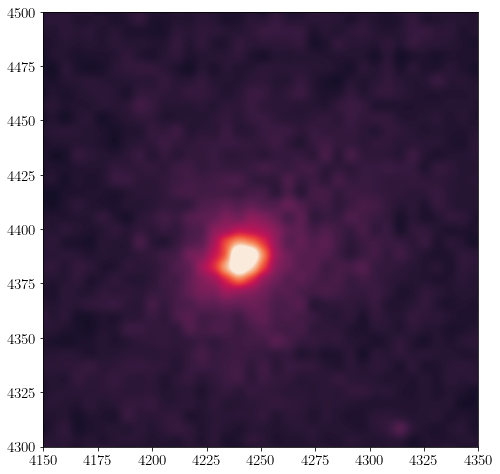

In [11]:
data = craw_hdu.data
x = data['x']
y = data['y']

# binning can be as fine as you want, down to maybe ~1/2 of the native pixel size
nbins = (250, 250)

img_data, yedges, xedges = np.histogram2d(x, y, nbins)
extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
cmap=sns.color_palette("rocket", as_cmap=True)

fig, ax = plt.subplots()
ax.imshow(img_data, extent=extent, cmap=cmap, vmax=150,
            origin='lower', interpolation='gaussian')

plt.xlim(4150,4350)
plt.ylim(4300,4500)


### 2. Unsharp Masks

Made in CIAO by dividing the image smoothed with a x radius Gaussian by one smoothed with a y radius Gaussian
- x" -  y"
- 0.98" - 9.8"
- 1.5" - 8"
- 1.5" - 10"
- 2" - 10"
- 0.7" - 6"
- 1" - 8"
- 1" - 6"

In [12]:
#unsharp masks
#bin 1:
fum_b1_098_98 = ''.join((other_chandra_path, 'bin1_broad_flux_um_098_98.img'))
fum_b1_15_8 = ''.join((other_chandra_path, 'bin1_broad_flux_um_15_8.img'))
fum_b1_15_10 = ''.join((other_chandra_path, 'bin1_broad_flux_um_15_10.img'))
fum_b1_2_10 = ''.join((other_chandra_path, 'bin1_broad_flux_um_2_10.img'))
fum_b1_07_6 = ''.join((other_chandra_path, 'bin1_broad_flux_um_07_6.img'))
fum_b1_1_8 = ''.join((other_chandra_path, 'bin1_broad_flux_um_1_8.img'))
fum_b1_1_6 = ''.join((other_chandra_path, 'bin1_broad_flux_um_1_6.img'))

um_b1_files = [fum_b1_098_98, fum_b1_15_8, fum_b1_15_10, fum_b1_2_10, fum_b1_07_6, 
            fum_b1_1_8, fum_b1_1_6]

#bin2: 
fum_b2_098_98 = ''.join((other_chandra_path, 'bin2_broad_flux_um_098_98.img'))
fum_b2_15_8 = ''.join((other_chandra_path, 'bin2_broad_flux_um_15_8.img'))
fum_b2_15_10 = ''.join((other_chandra_path, 'bin2_broad_flux_um_15_10.img'))
fum_b2_2_10 = ''.join((other_chandra_path, 'bin2_broad_flux_um_2_10.img'))
fum_b2_07_6 = ''.join((other_chandra_path, 'bin2_broad_flux_um_07_6.img'))
fum_b2_1_8 = ''.join((other_chandra_path, 'bin2_broad_flux_um_1_8.img'))
fum_b2_1_6 = ''.join((other_chandra_path, 'bin2_broad_flux_um_1_6.img'))

um_b2_files = [fum_b2_098_98, fum_b2_15_8, fum_b2_15_10, fum_b2_2_10, fum_b2_07_6, 
            fum_b2_1_8, fum_b2_1_6]

#bin4:
fum_b4_098_98 = ''.join((other_chandra_path, 'bin4_broad_flux_um_098_98.img'))
fum_b4_15_8 = ''.join((other_chandra_path, 'bin4_broad_flux_um_15_8.img'))
fum_b4_15_10 = ''.join((other_chandra_path, 'bin4_broad_flux_um_15_10.img'))
fum_b4_2_10 = ''.join((other_chandra_path, 'bin4_broad_flux_um_2_10.img'))
fum_b4_07_6 = ''.join((other_chandra_path, 'bin4_broad_flux_um_07_6.img'))
fum_b4_1_8 = ''.join((other_chandra_path, 'bin4_broad_flux_um_1_8.img'))
fum_b4_1_6 = ''.join((other_chandra_path, 'bin4_broad_flux_um_1_6.img'))

um_b4_files = [fum_b4_098_98, fum_b4_15_8, fum_b4_15_10, fum_b4_2_10, fum_b4_07_6, 
            fum_b4_1_8, fum_b4_1_6]

um_labels = ['0.98" - 9.8"', '1.5" - 8"', '1.5" - 10"', '2" - 10"', 
            '0.7" - 6"', '1" - 8"', '1" - 6"']

In [13]:
um_b1_hdus, um_b1_hdrs, um_b1_wcs = [], [], []

for um_file in um_b1_files:
    un_msk_hdu, un_msk_hdr, un_msk_wcs = pf.open_fits(um_file)
    um_b1_hdus.append(un_msk_hdu)
    um_b1_hdrs.append(un_msk_hdr)
    um_b1_wcs.append(un_msk_wcs)

um_b2_hdus, um_b2_hdrs, um_b2_wcs = [], [], []

for um_file in um_b2_files:
    un_msk_hdu, un_msk_hdr, un_msk_wcs = pf.open_fits(um_file)
    um_b2_hdus.append(un_msk_hdu)
    um_b2_hdrs.append(un_msk_hdr)
    um_b2_wcs.append(un_msk_wcs)

um_b4_hdus, um_b4_hdrs, um_b4_wcs = [], [], []

for um_file in um_b4_files:
    un_msk_hdu, un_msk_hdr, un_msk_wcs = pf.open_fits(um_file)
    um_b4_hdus.append(un_msk_hdu)
    um_b4_hdrs.append(un_msk_hdr)
    um_b4_wcs.append(un_msk_wcs)

divide by zero encountered in true_divide
invalid value encountered in true_divide


(342.0, 382.0, 342.0, 382.0)

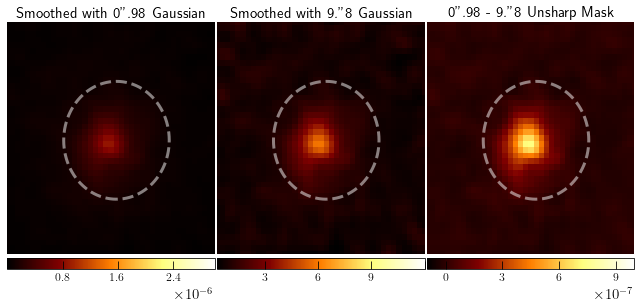

In [17]:
#compare smoothed images vs unsharp mask
fig = plt.figure(figsize=(15, 10))
gs1 = GridSpec(2, 4)
gs1.update(wspace=0.01)

cmap = cm.afmhot

ax1 = fig.add_subplot(gs1[0], projection=WCS(cg1_hdr))
chandra_zoom = [sf.sdss1531_dict['ra']+ 6e-4, sf.sdss1531_dict['dec'], 20 * u.arcsec]
ax1, cb = pf.ax_fits_map(hdu=None, data=cg1_hdu.data, hdr=cg1_hdr,
                vmin=0, vmax=3e-6, cmap=cmap, 
                coords=chandra_zoom, ax=ax1, contour=False, 
                clip=None, location='bottom', cbar=True)
ax1.axis('off')
pf.add_circle(ax1, [sf.sdss1531_dict['ra'], sf.sdss1531_dict['dec']], 10 * u.arcsec, 
                    color='w', coord_frame='fk5', lw=3, alpha=0.5, sphere=True) 
ax1.set_title('Smoothed with 0".98 Gaussian') 

ax2 = fig.add_subplot(gs1[1], projection=WCS(cg1_hdr))
ax2, cb = pf.ax_fits_map(hdu=None, data=cg1_hdu.data/cg10_hdu.data, hdr=cg1_hdr,
                vmin=0.3, vmax=12, cmap=cmap, 
                coords=chandra_zoom, ax=ax2, contour=False, 
                clip=None, location='bottom', cbar=True)
pf.add_circle(ax2, [sf.sdss1531_dict['ra'], sf.sdss1531_dict['dec']], 10 * u.arcsec, 
                    color='w', coord_frame='fk5', lw=3, alpha=0.5, sphere=True)   
ax2.axis('off')
ax2.set_title('Smoothed with 9."8 Gaussian') 

ax3 = fig.add_subplot(gs1[2], projection=WCS(cun_msk_hdr))
ax3, cb = pf.ax_fits_map(hdu=None, data=cun_msk_hdu.data, hdr=cun_msk_hdr,
                vmin=-1e-7, vmax=1e-6, cmap=cmap, 
                coords=chandra_zoom, ax=ax3, contour=False, 
                clip=None, location='bottom', cbar=True)
pf.add_circle(ax3, [sf.sdss1531_dict['ra'], sf.sdss1531_dict['dec']], 10 * u.arcsec, 
                    color='w', coord_frame='fk5', lw=3, alpha=0.5, sphere=True)
ax3.set_title('0".98 - 9."8 Unsharp Mask') 
ax3.axis('off')

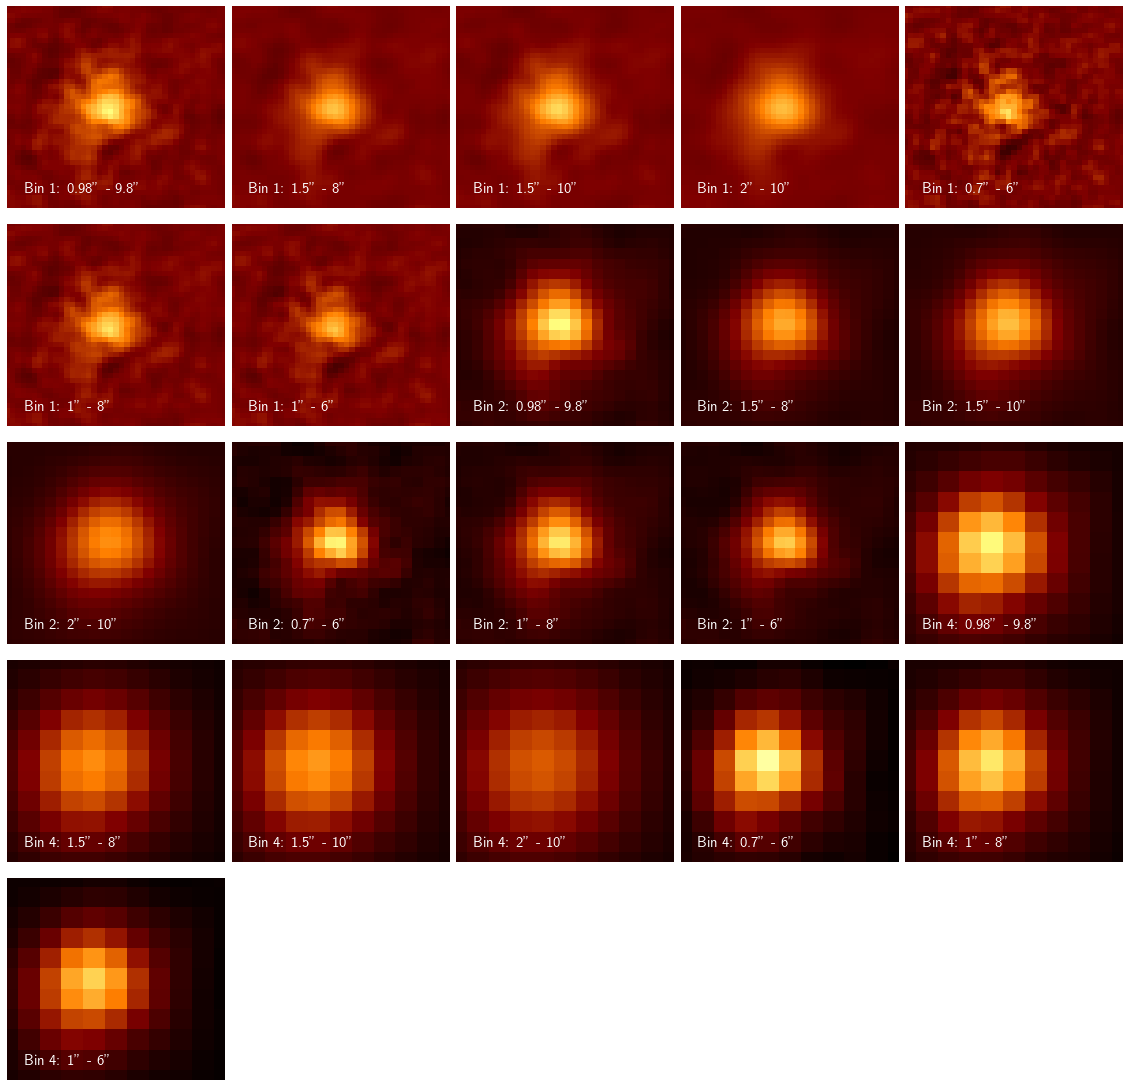

In [18]:
#plot all unsharp mask images for all binnings

fig = plt.figure(figsize=(20, 20))
gs1 = GridSpec(5, 5)
gs1.update(wspace=0.03, hspace=0.01)

cmap = cm.afmhot
chandra_zoom = [232.7940588,34.2402090, 10 * u.arcsec]

clims =[[-1e-7, 3e-7], [-1e-7, 1e-6], [-1e-7, 3e-6]]
files = um_b1_files + um_b2_files + um_b4_files
file_labels = um_labels + um_labels + um_labels
hdus = um_b1_hdus + um_b2_hdus + um_b4_hdus
data_hdrs = um_b1_hdrs + um_b2_hdrs + um_b4_hdrs

data_maps = [unmsk_hdu.data for unmsk_hdu in hdus]
axs = []


# um_hdus, um_hdrs, um_wcs
for id_subplot in range(21):
    if id_subplot < 7:
        clim = clims[0]
    if id_subplot > 6 and id_subplot < 14:
        clim = clims[1]
    if id_subplot > 13 :
        clim = clims[2]
    # um_hdus, um_hdrs, um_wcs
    um_file = files[id_subplot]
    data = data_maps[id_subplot]
    hdr = data_hdrs[id_subplot]

    ax = fig.add_subplot(gs1[id_subplot], projection=WCS(hdr))

    ax, cb = pf.ax_fits_map(hdu=None, data=data, hdr=hdr,
                        vmin=clim[0], vmax=clim[1], cmap=cmap, 
                        coords=chandra_zoom, ax=ax, contour=False, 
                        clip=None, lw=5, location='bottom', 
                        cbar=False)
    # ax.set_title(um_labels[id_subplot])
    xlim, ylim = ax.get_xlim(), ax.get_ylim()
    txt = 'Bin {}: {}'.format(um_file[38], file_labels[id_subplot])
    ax.text(xlim[0] + (xlim[1] - xlim[0]) *0.08, ylim[0] + (ylim[1] - ylim[0]) *0.08, 
            txt, color='w')

    ax.axis('off')

fig.savefig(fig_path + 'chandra_unsharp_masks.pdf')

### 3. Plot Wavelet Fit Image

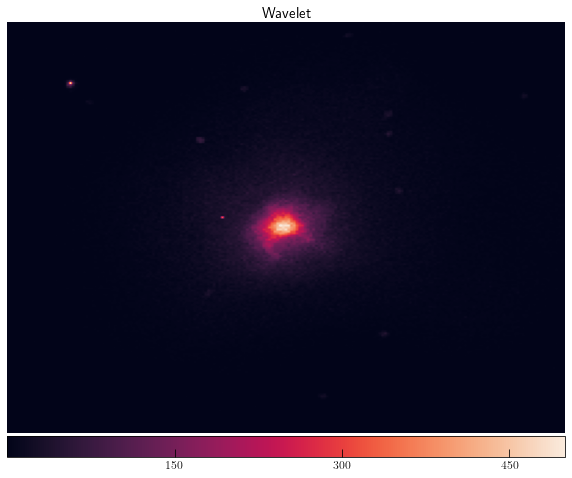

In [25]:
#draw
fig = plt.figure(figsize=(10, 8))
gs1 = GridSpec(1, 1)

cmap=sns.color_palette("rocket", as_cmap=True)
chandra_zoom = [232.7940588,34.2402090, 50 * u.arcsec]

clims=[[0, 500]]
data_maps = [cwav_hdu.data]
axs = []

for id_subplot in range(1):
    clim = clims[id_subplot]
    data = data_maps[id_subplot]

    ax = fig.add_subplot(gs1[id_subplot], projection=WCS(cwav_hdr))

    ax, cb = pf.ax_fits_map(hdu=None, data=data, hdr=cwav_hdr,
                        vmin=clim[0], vmax=clim[1], cmap=cmap, 
                        coords=chandra_zoom, ax=ax, contour=False, 
                        clip=None, lw=5, location='bottom')
    ax.set_title('Wavelet')

    ax.axis('off')

### 4. Quantify size of X-ray "wings"

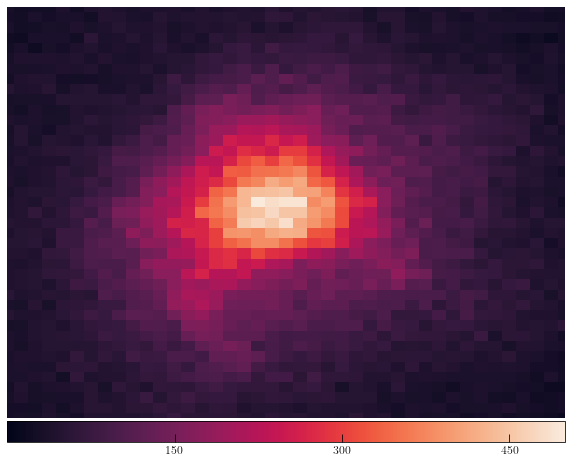

In [28]:
#zoom in
fig = plt.figure(figsize=(10, 8))
gs1 = GridSpec(1, 1)

cmap=sns.color_palette("rocket", as_cmap=True)
chandra_zoom = [232.7940588,34.2402090, 10 * u.arcsec]

clims=[[0, 500]]
data_maps = [cwav_hdu.data]
axs = []

for id_subplot in range(1):
    clim = clims[id_subplot]
    data = data_maps[id_subplot]

    ax = fig.add_subplot(gs1[id_subplot], projection=WCS(cwav_hdr))

    ax, cb = pf.ax_fits_map(hdu=None, data=data, hdr=cwav_hdr,
                        vmin=clim[0], vmax=clim[1], cmap=cmap, 
                        coords=chandra_zoom, ax=ax, contour=False, 
                        clip=None, lw=5, location='bottom')

    ax.axis('off')

In [26]:
#ds9 
# left wing is 6.721"
# right wing is 4.546" 

In [29]:
right_wing_kpc = 4.546 * u.arcsec * kpc_per_arcsec
left_wing_kpc = 6.721 * u.arcsec * kpc_per_arcsec

In [30]:
print("Right wing length: {:.2f}".format(right_wing_kpc))
print("Left wing length: {:.2f}".format(left_wing_kpc))

Right wing length: 21.67 kpc
Left wing length: 32.04 kpc
